In [20]:
import cv2
import numpy as np
from ultralytics import YOLO
from PIL import Image
import io
import os
import requests
import matplotlib.pyplot as plt

In [32]:
model_name = 'YOLOv8'
imageUrl = 'https://i.imgur.com/LYfPw6j.png' 
#imageUrl = 'https://fastpacehealth.com/wp-content/uploads/2023/09/Compound-Fracture-817x470.jpg'
confidenceThreshold = 0.5

In [33]:
# Use a custom User-Agent to mimic a browser
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

# Make the request with the custom headers and allow redirects
response = requests.get(imageUrl, headers=headers, allow_redirects=True)

# Check if the request was successful
if response.status_code == 200:
    #print("Request successful")
    #print("Content type:", response.headers.get('content-type'))
    #print("Content length:", len(response.content))
    image = Image.open(io.BytesIO(response.content))
    print('image loaded')
    # Convert PIL Image to OpenCV format
    downloaded_opencv_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

else:
    print("Request failed with status code:", response.status_code)


image loaded


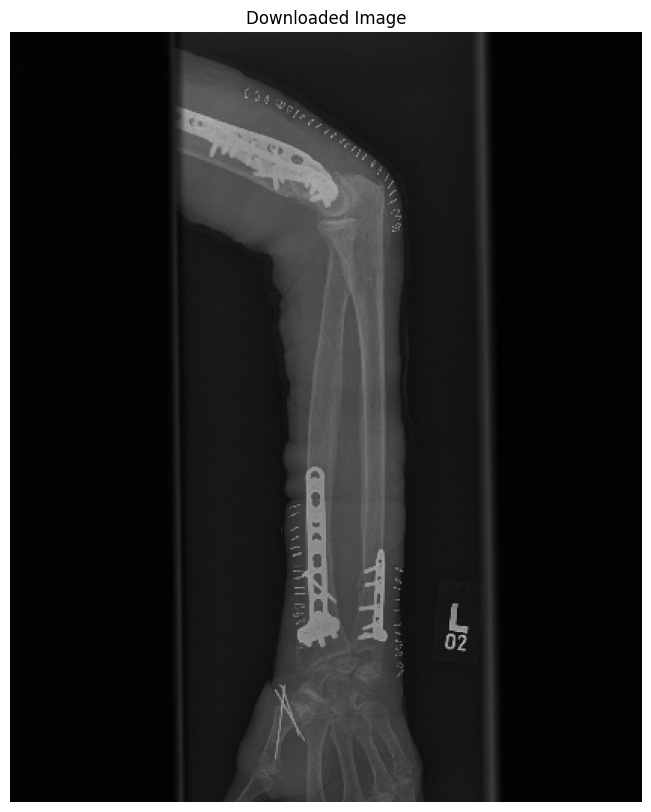

In [34]:
# Plot the downloaded_opencv_image
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(downloaded_opencv_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Downloaded Image')
plt.show()



In [15]:
# Load the specified YOLO model
model = YOLO(f"weights/{model_name}.pt")
# Run inference
results = model(downloaded_opencv_image, conf=confidenceThreshold)[0]
#print(results)


0: 384x640 2 fractures, 316.2ms
Speed: 41.7ms preprocess, 316.2ms inference, 35.0ms postprocess per image at shape (1, 3, 384, 640)


In [ ]:
# Process results and draw bounding boxes
for result in results.boxes.data.tolist():
    x1, y1, x2, y2, score, class_id = result
    if score > confidenceThreshold:
        cv2.rectangle(downloaded_opencv_image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(downloaded_opencv_image, f"{model.names[int(class_id)]}: {score:.2f}", 
                    (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
# Convert OpenCV image to RGB for displaying with matplotlib
rgb_image = cv2.cvtColor(downloaded_opencv_image, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(12, 8))
plt.imshow(rgb_image)
plt.axis('off')
plt.title('Processed Image with Detections')
plt.show()


# Prepare detection results
detections = [
    {
        "class": model.names[int(box.cls)],
        "confidence": float(box.conf),
        "bbox": box.xyxy.tolist()[0]
    } for box in results.boxes
]
print(detections)

In [35]:
# Get all YOLO model files in the weights folder
model_files = [f for f in os.listdir('weights') if f.startswith('YOLO') and f.endswith('.pt')]

all_results = []

for model_file in model_files:
    # Load the YOLO model
    print(f"Loading model: {model_file}")
    model = YOLO(f"weights/{model_file}")
    
    # Run inference
    results = model(downloaded_opencv_image, conf=confidenceThreshold)[0]
    
    # Prepare detection results
    detections = [
        {
            "model": model_file,
            "class": model.names[int(box.cls)],
            "confidence": float(box.conf),
            "bbox": box.xyxy.tolist()[0]
        } for box in results.boxes
    ]
    
    all_results.extend(detections)

print(all_results)




Loading model: YOLOv10_l.pt

0: 640x544 3 metals, 1 text, 717.0ms
Speed: 4.0ms preprocess, 717.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)
Loading model: YOLOv10_m.pt

0: 640x544 1 fracture, 4 metals, 1 text, 421.1ms
Speed: 3.5ms preprocess, 421.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)
Loading model: YOLOv10_n.pt

0: 640x544 3 metals, 1 text, 101.9ms
Speed: 2.3ms preprocess, 101.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)
Loading model: YOLOv10_s.pt

0: 640x544 5 metals, 1 text, 239.0ms
Speed: 0.0ms preprocess, 239.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)
Loading model: YOLOv8.pt

0: 640x544 4 metals, 1 text, 182.6ms
Speed: 3.3ms preprocess, 182.6ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 544)
Loading model: YOLOv9_c.pt

0: 640x544 1 fracture, 4 metals, 1 text, 514.2ms
Speed: 3.5ms preprocess, 514.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 5

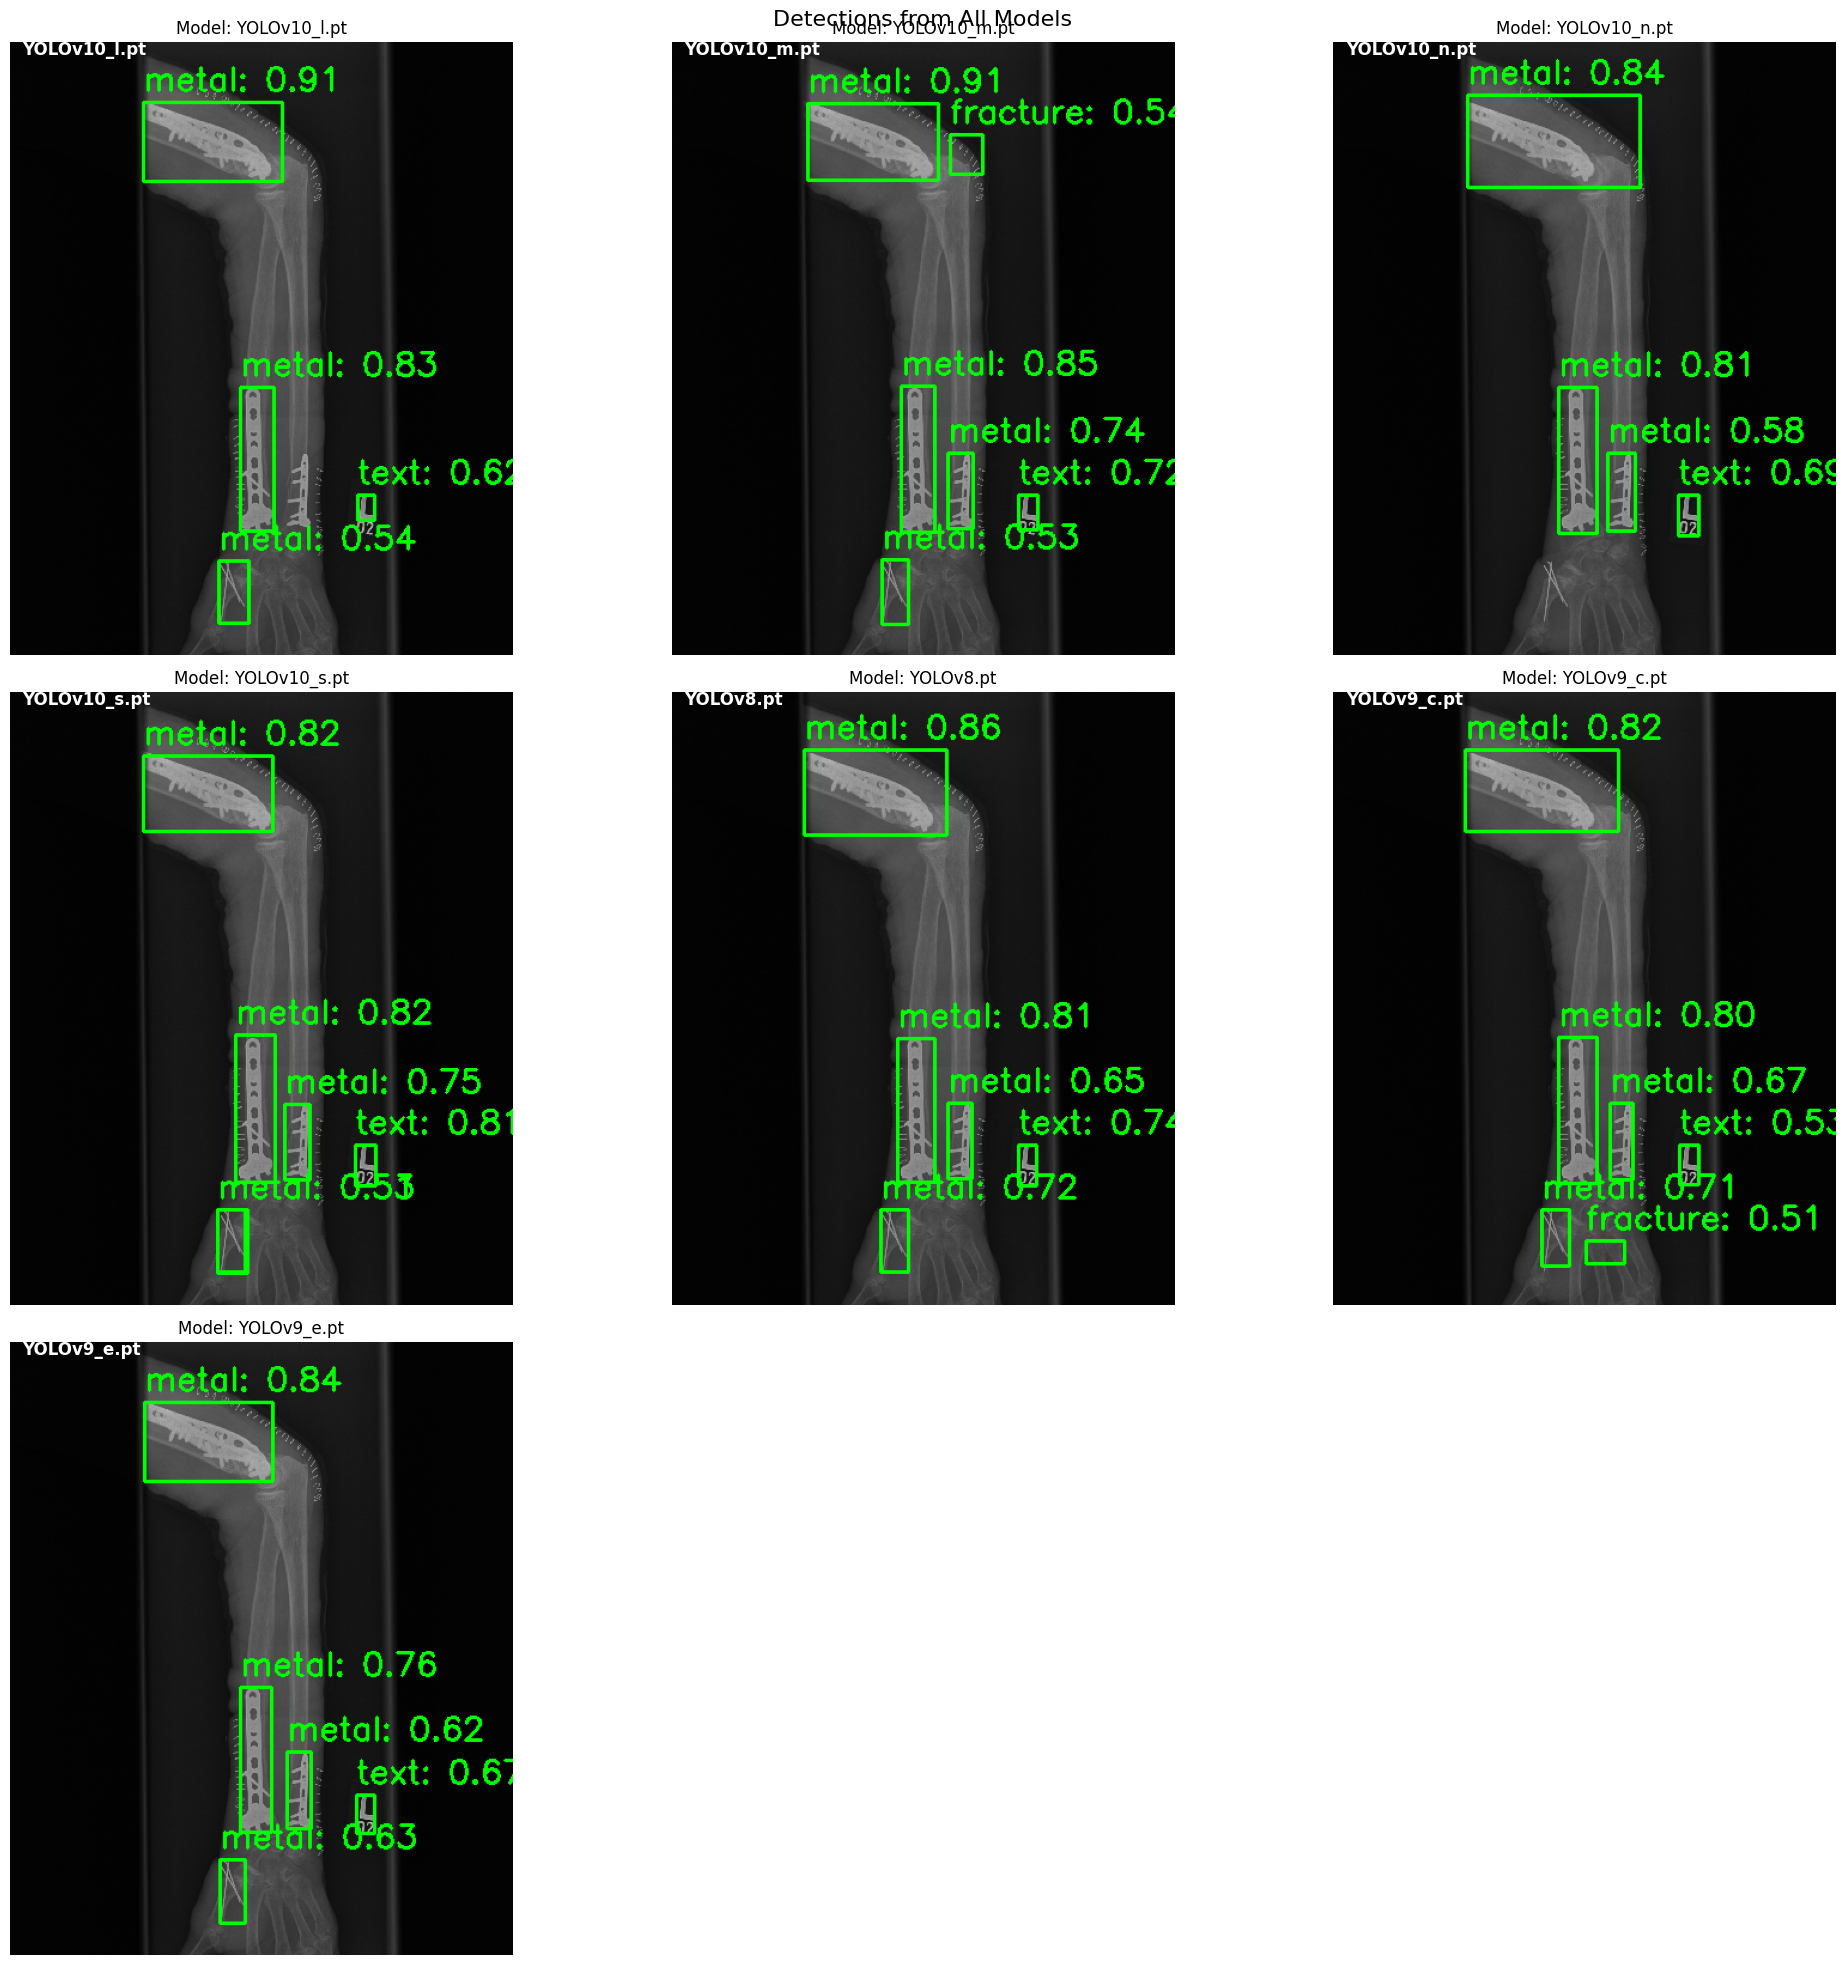

In [36]:

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
fig.suptitle('Detections from All Models', fontsize=16)

# Flatten the axes array for easier iteration
axes_flat = axes.flatten()

# Ensure we have a copy of the original image for each subplot
images = [downloaded_opencv_image.copy() for _ in range(9)]

# Group detections by model
detections_by_model = {}
for detection in all_results:
    model = detection['model']
    if model not in detections_by_model:
        detections_by_model[model] = []
    detections_by_model[model].append(detection)

# Draw bounding boxes for each model
for i, (model, detections) in enumerate(detections_by_model.items()):
    if i >= 9:  # We only have 9 subplots
        break
    
    for detection in detections:
        x1, y1, x2, y2 = map(int, detection['bbox'])
        cv2.rectangle(images[i], (x1, y1), (x2, y2), (0, 255, 0), 2)
        label = f"{detection['class']}: {detection['confidence']:.2f}"
        cv2.putText(images[i], label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    # Display the image in the corresponding subplot
    axes_flat[i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    axes_flat[i].set_title(f"Model: {model}")
    axes_flat[i].axis('off')
    #display the model name
    axes_flat[i].text(10, 10, model, color='white', fontsize=12, fontweight='bold')

# Remove any unused subplots
for j in range(i+1, 9):
    fig.delaxes(axes_flat[j])

plt.tight_layout()
plt.show()